# This mini-project will focus on processing and replacing missing values in a dataset. 
- The dataset chosen or generated must have a sufficient number of missing values to contribute to the main objective of this project.
- Each part in the project must be accompanied by a clear, valid, and detailed explanation, along with the corresponding code blocks.
- Respect exactly the same number of cells. Your marks will be strongly infuenced by the respect of this structure.

In [1]:
# Install and import required packages
!pip install -q statsmodels

import math
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import time series analysis tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

# Custom visualization settings for better plot appearance
custom_rc = {
   # fonts
   'font.weight': 'bold',
   'font.family': 'cambria',
   'font.size': 15,
   # axes
   'axes.labelweight': 'bold',
   'axes.grid': True,
   # grid
   'grid.color': 'gray',
   'grid.linestyle': '--',
   'grid.linewidth': 0.6,
   # lines
   'lines.linewidth': 2,
   # ticks
   'xtick.color': '#227574',
   'ytick.color': '#227574',
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'xtick.direction': 'out',
   'ytick.direction': 'out'
}
sns.set_style("whitegrid", rc=custom_rc)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---
# 1. Choose an existing dataset or generate a synthetic one.
- If generated, describe how you ensure the quality of the synthetic data.
- If chosen, justify your choice, and provide a general desciption. 
- In all cases, cite your objectives, and your working plan. 
- Provide code.
- As an objective, you may use *** simple regression model, or a clustering algorithm***. 
---

## Answer

### 1. Chosen Data
The data chosen is the Jena Climate dataset, which contains weather measurements from the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany, spanning from 2009 to 2017.

### 2. Justification
This comprehensive time series dataset provides an excellent foundation for analytical exploration. Its extensive temporal coverage and diverse meteorological measurements make it particularly valuable for learning purposes, enabling in-depth work in data preprocessing, feature engineering, modeling, hypothesis testing, and insight generation.

### 3. Data Description
The Jena Climate dataset represents a detailed meteorological time series recorded at the Max Planck Institute's Weather Station. It captures 14 distinct atmospheric measurements at 10-minute intervals from January 1st, 2009, to December 31st, 2016.

#### Columns Description

| Index | Feature | Format | Description |
|:------|:--------|:-------|:------------|
| 1 | Date Time | 01.01.2009 00:10:00 | Date-time reference for each measurement |
| 2 | Pressure (mbar) | 996.52 | Atmospheric pressure measured in millibars, a standard meteorological unit |
| 3 | Temperature (°C) | -8.02 | Temperature measurement in Celsius scale |
| 4 | Temperature (K) | 265.4 | Temperature measurement in Kelvin scale |
| 5 | Dew Point (°C) | -8.9 | Temperature at which water vapor condenses, indicating air moisture content |
| 6 | Relative Humidity (%) | 93.3 | Percentage measure of air saturation with water vapor |
| 7 | Saturation Vapor Pressure (mbar) | 3.33 | Maximum possible vapor pressure at current temperature |
| 8 | Vapor Pressure (mbar) | 3.11 | Current water vapor pressure in the air |
| 9 | Vapor Pressure Deficit (mbar) | 0.22 | Difference between actual and potential vapor pressure |
| 10 | Specific Humidity (g/kg) | 1.94 | Mass ratio of water vapor to total air mass |
| 11 | Water Vapor Concentration (mmol/mol) | 3.12 | Molecular concentration of water vapor in air |
| 12 | Air Density (g/m³) | 1307.75 | Mass of air per cubic meter |
| 13 | Wind Speed (m/s) | 1.03 | Current wind velocity measurement |
| 14 | Maximum Wind Speed (m/s) | 1.75 | Peak wind velocity recorded |
| 15 | Wind Direction (°) | 152.3 | Wind direction measured in degrees |

*Source: [Kaggle - Jena Climate Dataset](https://www.kaggle.com/datasets/mnassrib/jena-climate)*

### 4. Load and general understanding of the data

In [2]:
# Load and preprocess the Jena Climate dataset
filepath = "dataset/jena_climat_dataset_2009_2017.csv"
weather = pd.read_csv(filepath)

# Convert datetime string to pandas datetime type and set as index
weather['datetime'] = pd.to_datetime(weather['datetime'], format="%d/%m/%Y %H:%M") 
weather = weather.set_index('datetime').sort_index()

In [3]:
# Display initial dataset overview and basic statistics
print("1. Dataset Preview:", "="*50)
print(weather.iloc[1])

print("\n2. Data Exploration:", "="*50)

print("\na. Dataset Structure and Information")
print(weather.info())

print("\nb. Statistical Summary")
# Select key weather parameters for analysis
columns = ["potential_temperature (kelvin)", "relative_humidity (%)", "pressure (mbar)"] 
print(weather[columns].describe())

print("\nDataset Dimensions:")
print(f'Shape = {weather.shape}')

1. Dataset Preview: ==================================================
pressure (mbar)                    996.50
potential_temperature (kelvin)        NaN
dew_point (celsius)                 -8.90
relative_humidity (%)               93.30
max_vapor_pressure (mbar)            3.33
actual_vapor_pressure (mbar)         3.11
vapor_pressure_deficit (mbar)        0.22
specific_humidity (g/kg)             1.94
water_concentration (mmol/mol)       3.12
air_density (g/m**3)              1308.00
wind_speed (m/s)                     1.03
max_wind_speed (m/s)                 1.75
wind_direction (degrees)           152.20
Name: 2009-01-01 00:10:00, dtype: float64

2. Data Exploration: ==================================================

a. Dataset Structure and Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 481489 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------            

### 5. Objective
The primary objective is to **forecast temperature  (in degrees Celsius)** based on historical weather data. This involves leveraging the rich time series data from the Jena Climate dataset to predict future temperature values. Such forecasts can provide valuable insights for climate modeling and help in planning activities sensitive to temperature changes.


### 6. Working Plan

#### Step 1: Data cleaning
- identify null values
- apply relevan technics to remove them
- select relevant features and drop the others

#### Step 2: Exploratory Data Analysis (EDA)
- visualize the data to understand it
- feature enginieering and exrtact meaningfull components
- check for stationarity and apply technics to remove non-stationarity like differencing
- Autocorrelation analysis to determine the required components for our last model

#### Step 4: Model Selection and Training
- split the data: experimental + validation
- chose the right model
- fit, predict, visualize the results and evaluate the model
- fin tuning the model
- results!

#### Step 6: Conclusion
- final conclusion of the project


# 2. Clean your data: 
- Evaluate the quality of data.
- Identify relevant features.
- Missing values or any additional operations ? (use different missing appraoches to tackle the missing values issue, create different data variants for a later comparison).   
- statistics, check data types, conversions and more ?
- Divide data into two parts one for experiments, another portion for validation (explain the logic of your splitting).
---

##  a. Explore the dataset:
We already did! Check [*Loading an generat undestanding of the data*](#4.-Load-and-general-understanding-of-the-data)


## b. Handle missing values:
   - Identify missing values in the dataset.

In [4]:
weather.isnull().sum()

pressure (mbar)                        0
potential_temperature (kelvin)     52070
dew_point (celsius)                    0
relative_humidity (%)                  0
max_vapor_pressure (mbar)         337079
actual_vapor_pressure (mbar)           0
vapor_pressure_deficit (mbar)          0
specific_humidity (g/kg)           65131
water_concentration (mmol/mol)         0
air_density (g/m**3)                   0
wind_speed (m/s)                  100106
max_wind_speed (m/s)                   0
wind_direction (degrees)               0
dtype: int64

   - Employ appropriate techniques to fill or remove missing values.

Our data is highly detailed with 10-minute intervals between records. Downsampling to weekly intervals will provide significant benefits:
- Reduce the dataset dimensions while preserving key characteristics (trends, seasonality)
- Smooth the data by reducing noise
- Reduce the number of null values through aggregation

For this analysis, we will downsample to weekly intervals using maximum temperature values (weekly maximum temperature).

*Note: The high-frequency nature of our current data (10-minute intervals) provides more granularity than needed for effective temperature forecasting. Weekly aggregation will maintain essential patterns while optimizing our dataset for analysis.*

In [5]:
df = weather.resample('W').mean()
print(f"original shape: {weather.shape}, weekly resampled shape: {df.shape}")

original shape: (481489, 13), weekly resampled shape: (418, 13)


In [6]:
df.isnull().sum()

pressure (mbar)                   0
potential_temperature (kelvin)    0
dew_point (celsius)               0
relative_humidity (%)             0
max_vapor_pressure (mbar)         0
actual_vapor_pressure (mbar)      0
vapor_pressure_deficit (mbar)     0
specific_humidity (g/kg)          0
water_concentration (mmol/mol)    0
air_density (g/m**3)              0
wind_speed (m/s)                  0
max_wind_speed (m/s)              0
wind_direction (degrees)          0
dtype: int64

The weekly downsampling process has effectively eliminated null values from our dataset. This improvement in data quality stems from the mechanics of the mean aggregation function applied across weekly intervals. When calculating weekly means, the aggregation function considers all available records within each seven-day period. Importantly, even if some records within a week contain null values, the presence of just one valid measurement enables the calculation of a meaningful weekly average. This characteristic of the aggregation process ensures that our weekly dataset maintains continuity and completeness.

The resulting dataset not only addresses the null value challenge but also provides a more manageable temporal resolution for our subsequent analysis stages, while preserving the essential temperature patterns we aim to study.

- We will derive our target variable—temperature in Celsius—from the Kelvin measurements using the standard conversion formula: C = K - 273.15. This converted temperature data will serve as the primary variable for our time series analysis and forecasting.

In [7]:
df['temperature'] = df['potential_temperature (kelvin)'] - 273.15

**REMARK:** Time series can be either univariate or multivariate:
- Univariate time series only has a single time-dependent variable.
- Multivariate time series have a multiple time-dependent variable.

to simplify the work, we will work on a univariate time series forecasting. so, we need just the temperature indicator to forecast. other columns will be dropped

In [8]:
df = df[['temperature']]

---
# 3. Exploratory Data Analyses
- Describe the methodology you will follow to achieve your objectives, relatioships analysis ? feature engineering ? 
- Apply your appraoch, and cite your findings.
- Draft a conclusion, and define new operations.
- Use visaluzation to understand your findings.
---

## a. Vizualization

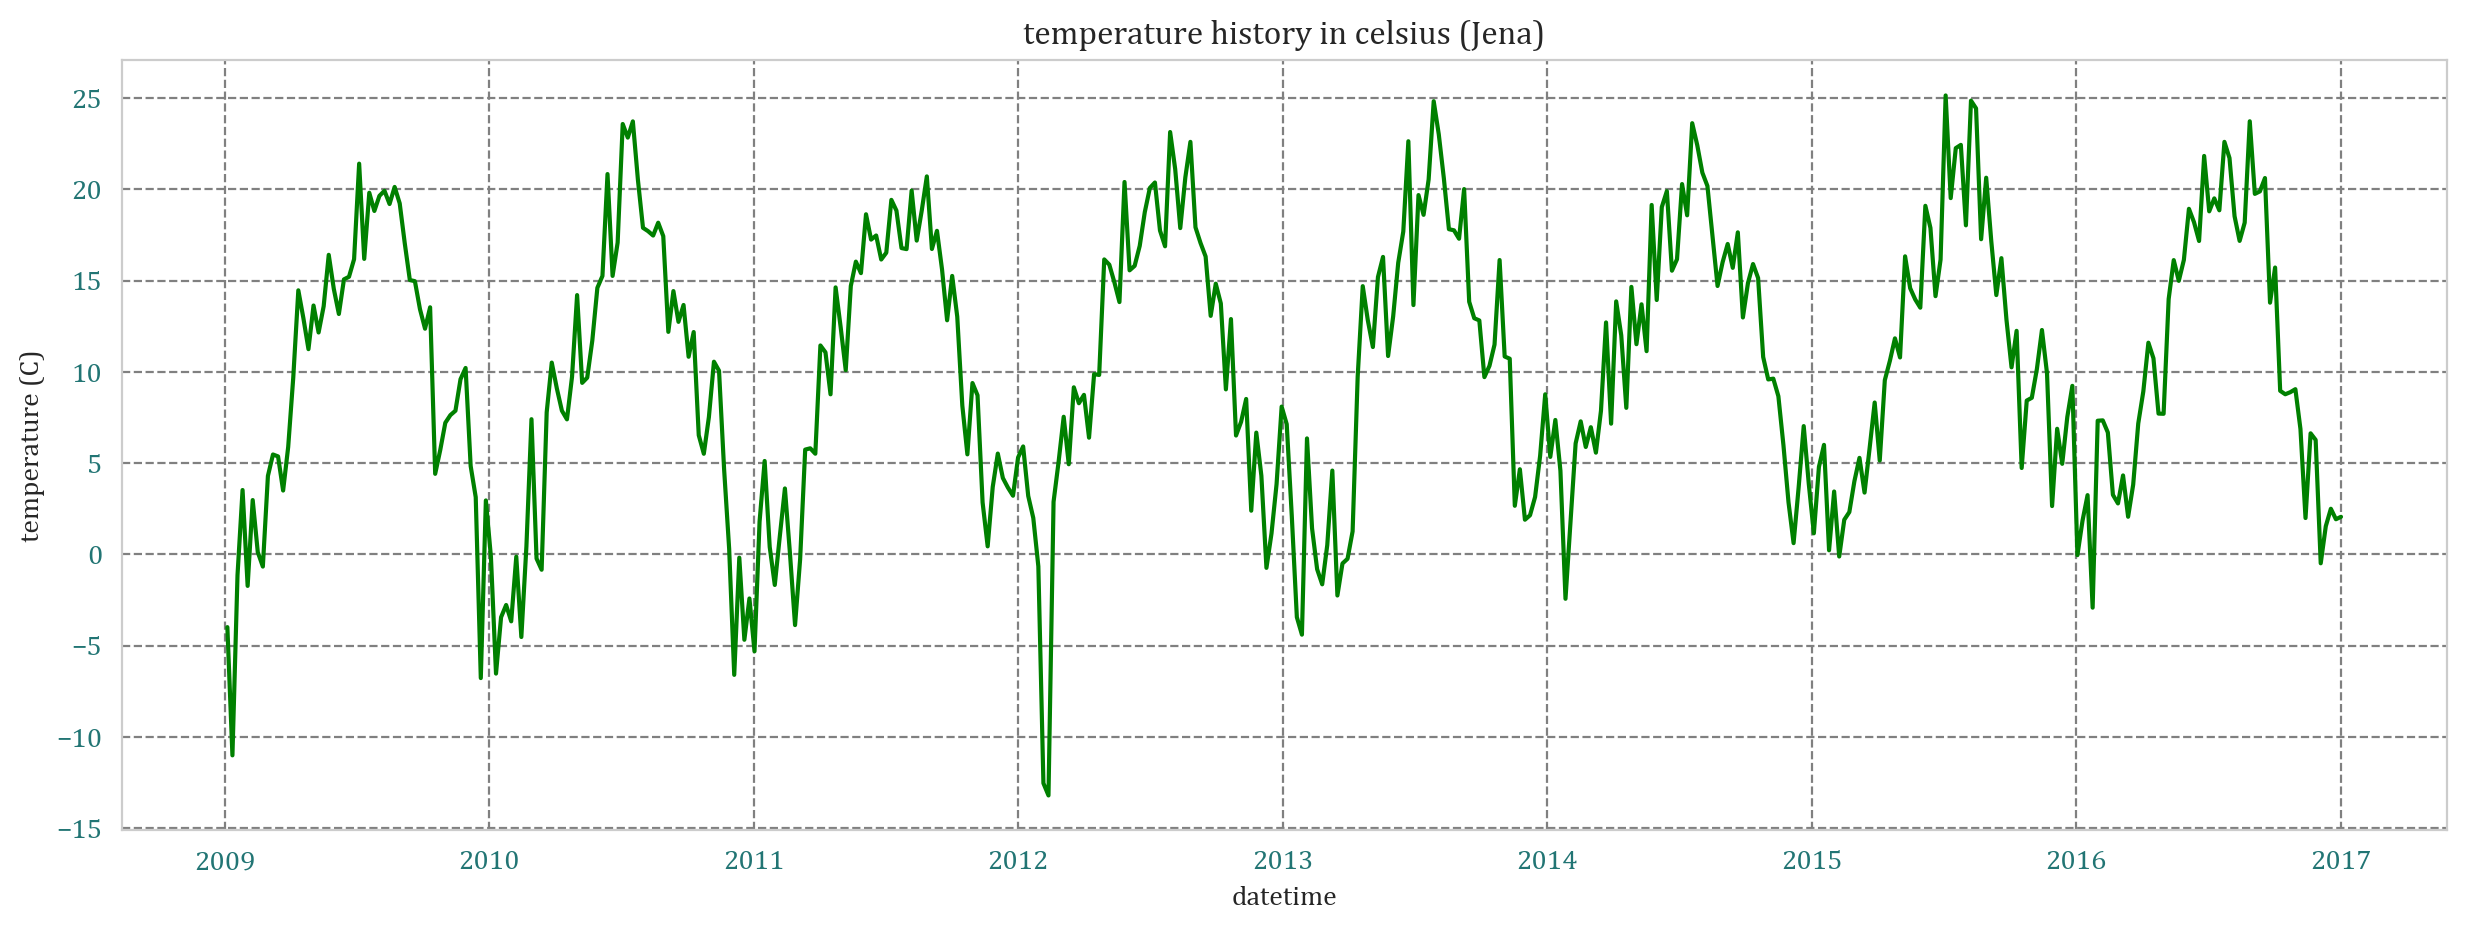

In [9]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=200)

sns.lineplot(x=df.index, y=df["temperature"], ax=ax, color="green")
ax.set_title('temperature history in celsius (Jena)')
ax.set_ylabel('temperature (C)')

plt.show()

## b. feature enginieering

Time series decomposition breaks down a series into its fundamental components: level, trend, seasonality, and noise. This decomposition provides valuable insights for time series analysis and forecasting.

The core components are defined as follows:

* **Level**: The baseline or average value that forms the foundation of the series
* **Trend**: The long-term increasing or decreasing pattern observed in the series
* **Seasonality**: The regular, periodic patterns that repeat at fixed intervals
* **Noise**: The random fluctuations or irregular variations that cannot be attributed to other components

This decomposition approach offers an effective framework for understanding time series behavior and developing appropriate analytical strategies. While level and noise are present in all time series, trend and seasonality are optional components that may or may not exist.

The components can combine in two primary ways:
* **Additive Model**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative Model**: $y(t) = Level * Trend * Seasonality * Noise$

For our analysis, we will utilize the seasonal_decompose() function from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library to perform this decomposition.

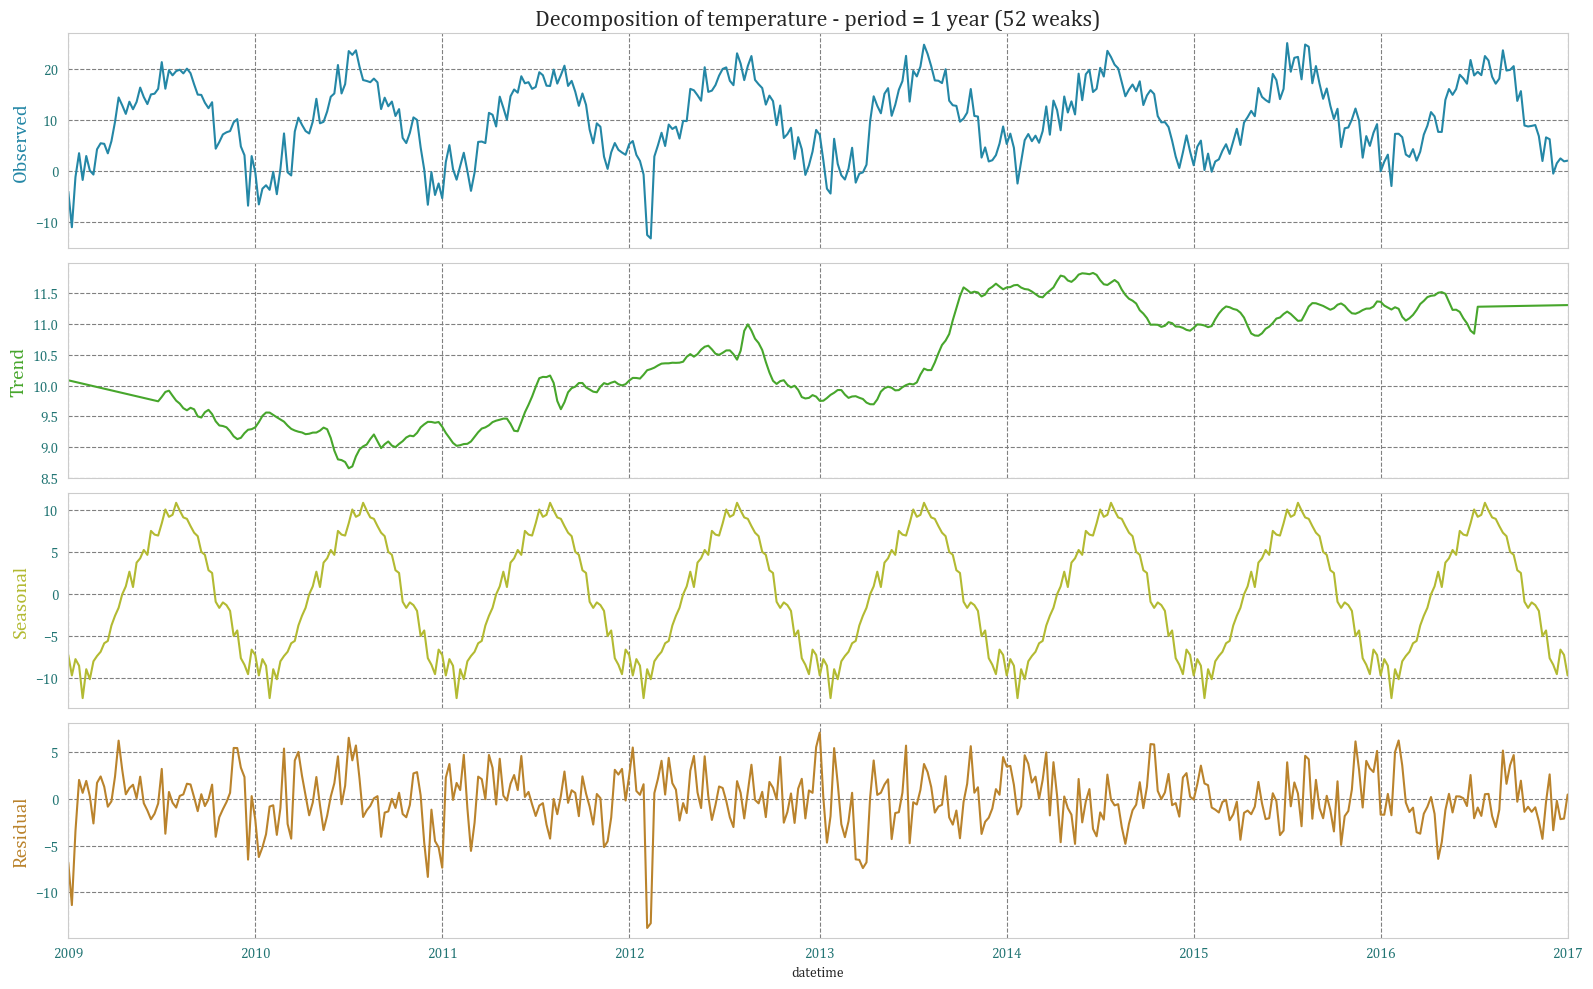

In [10]:
# Create subplots for decomposition visualization (4 rows, 1 column)
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,10))

# Perform seasonal decomposition with yearly period (52 weeks)
res = seasonal_decompose(df["temperature"], period=52, model='additive', extrapolate_trend='freq')

# Plot original time series data
ax[0].set_title(f'Decomposition of temperature - period = 1 year (52 weaks)', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='#2487A6')
ax[0].set_ylabel('Observed', fontsize=14, color='#2487A6')

# Plot trend component
res.trend.plot(ax=ax[1], legend=False, color='#47A62C')
ax[1].set_ylabel('Trend', fontsize=14, color='#47A62C')

# Plot seasonal component 
res.seasonal.plot(ax=ax[2], legend=False, color='#B3BA32')
ax[2].set_ylabel('Seasonal', fontsize=14, color='#B3BA32')

# Plot residual (noise) component
res.resid.plot(ax=ax[3], legend=False, color='#BA832C')
ax[3].set_ylabel('Residual', fontsize=14, color='#BA832C')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

## c. Stationarity

Stationarity is a critical assumption for many time series models, particularly ARIMA. A stationary time series maintains consistent statistical properties over time, characterized by three fundamental conditions:

* The mean remains constant and does not exhibit time dependency
* The variance stays stable and is not influenced by time
* The covariance demonstrates consistency and independence from time

There are three primary approaches to evaluate whether a time series exhibits stationarity:

1. **Visual Assessment**: Examination of the plotted time series data to identify potential trends or seasonal patterns
2. **Statistical Analysis**: Division of the time series into segments to compare mean and variance across different time periods
3. **Formal Statistical Testing**: Application of the Augmented Dickey-Fuller (ADF) test

For our analysis, we will employ the ADF test as our primary method to assess stationarity, as it provides a rigorous statistical foundation for our conclusions.

**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
* **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
* **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.

In [11]:
def adf_test_stationarity(data, column_name, significance_level=0.05):
   # Execute ADF test on the specified column
   test_results = adfuller(data[column_name].values)
   
   # Unpack test results for clarity
   adf_statistic, p_value, n_lags, n_obs, critical_values, icbest = test_results
   
   # Display comprehensive test results
   print(f"Augmented Dickey-Fuller Test Results for '{column_name}'")
   print("=" * 50)
   print(f"Number of lags used: {n_lags}")
   print(f"ADF test statistic: {adf_statistic:.4f}")
   print(f"P-value: {p_value:.4f}")
   print(f"Number of observations: {n_obs}")
   print("\nCritical Values:")
   for significance, value in critical_values.items():
       print(f"{significance}: {value:.4f}")
       
   # Evaluate stationarity based on p-value
   print("\nConclusion:")
   if p_value < significance_level:
       print(f"The series is STATIONARY (p-value {p_value:.4f} < {significance_level})")
   else:
       print(f"The series is NON-STATIONARY (p-value {p_value:.4f} >= {significance_level})")

adf_test_stationarity(df, 'temperature')

Augmented Dickey-Fuller Test Results for 'temperature'
Number of lags used: 18
ADF test statistic: -9.2147
P-value: 0.0000
Number of observations: 399

Critical Values:
1%: -3.4468
5%: -2.8688
10%: -2.5706

Conclusion:
The series is STATIONARY (p-value 0.0000 < 0.05)


## c. Lag Features

Understanding the correlation between current observations and their historical values is essential for time series analysis. By creating lag features at different time intervals, we can examine how past values influence future observations. This analysis is particularly crucial for determining the appropriate **D** parameter in the ARIMA model, which represents the number of lag differences required to achieve stationarity.

The correlation matrix visualization of these lag features provides valuable insights into the temporal dependencies within our data, helping us understand the predictive power of historical observations. This understanding guides us in selecting the optimal lag structure for our forecasting model, ensuring we capture meaningful patterns while avoiding unnecessary complexity.

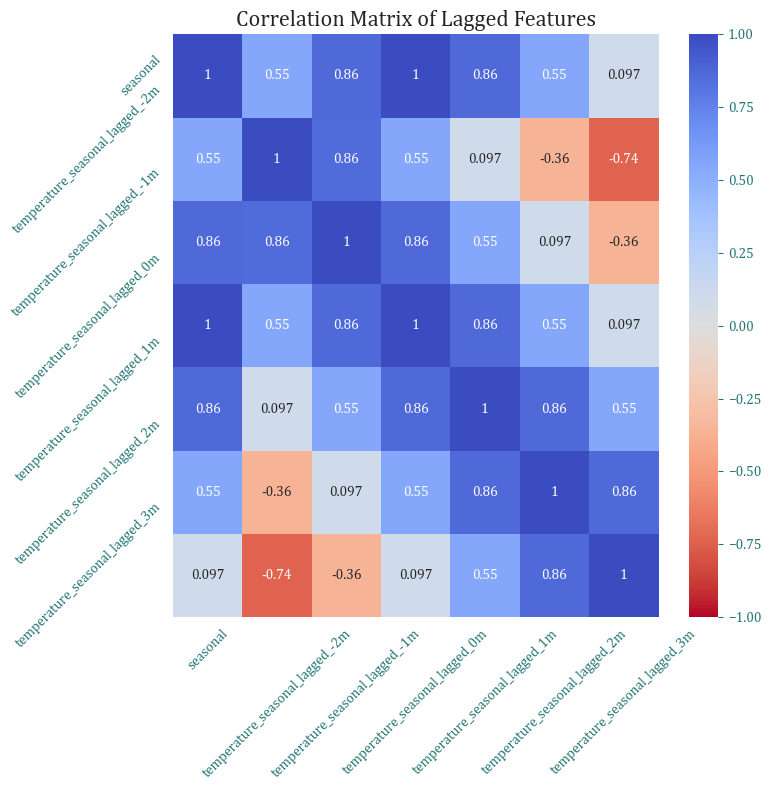

In [12]:
# Set up figure for correlation heatmap visualization
f, ax = plt.subplots(figsize=(8, 8))

# Define lag period (4 weeks = 1 month)
weeks_per_month = 4
df_with_lags = pd.DataFrame(res.seasonal)

# Create lagged features from -2 months to +3 months
for lag in range(-2, 4):
   lag_months = f"temperature_seasonal_lagged_{lag}m"
   df_with_lags[lag_months] = df_with_lags["seasonal"].shift(weeks_per_month * lag)

# Generate and plot correlation matrix
correlation_matrix = df_with_lags.corr()
sns.heatmap(correlation_matrix, 
           annot=True,               # Show correlation values
           vmin=-1, vmax=1,         # Set correlation range
           cmap='coolwarm_r',       # Use reversed coolwarm colormap
           ax=ax)

# Customize plot appearance
ax.set_title('Correlation Matrix of Lagged Features', fontsize=16)
ax.tick_params(rotation=45)          # Rotate labels for better readability

# Adjust layout and display
plt.tight_layout()
plt.show()

We remark high correlation between the seasonal component of the temperatrue with its lag for 1 month (4 weaks)

## d. Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

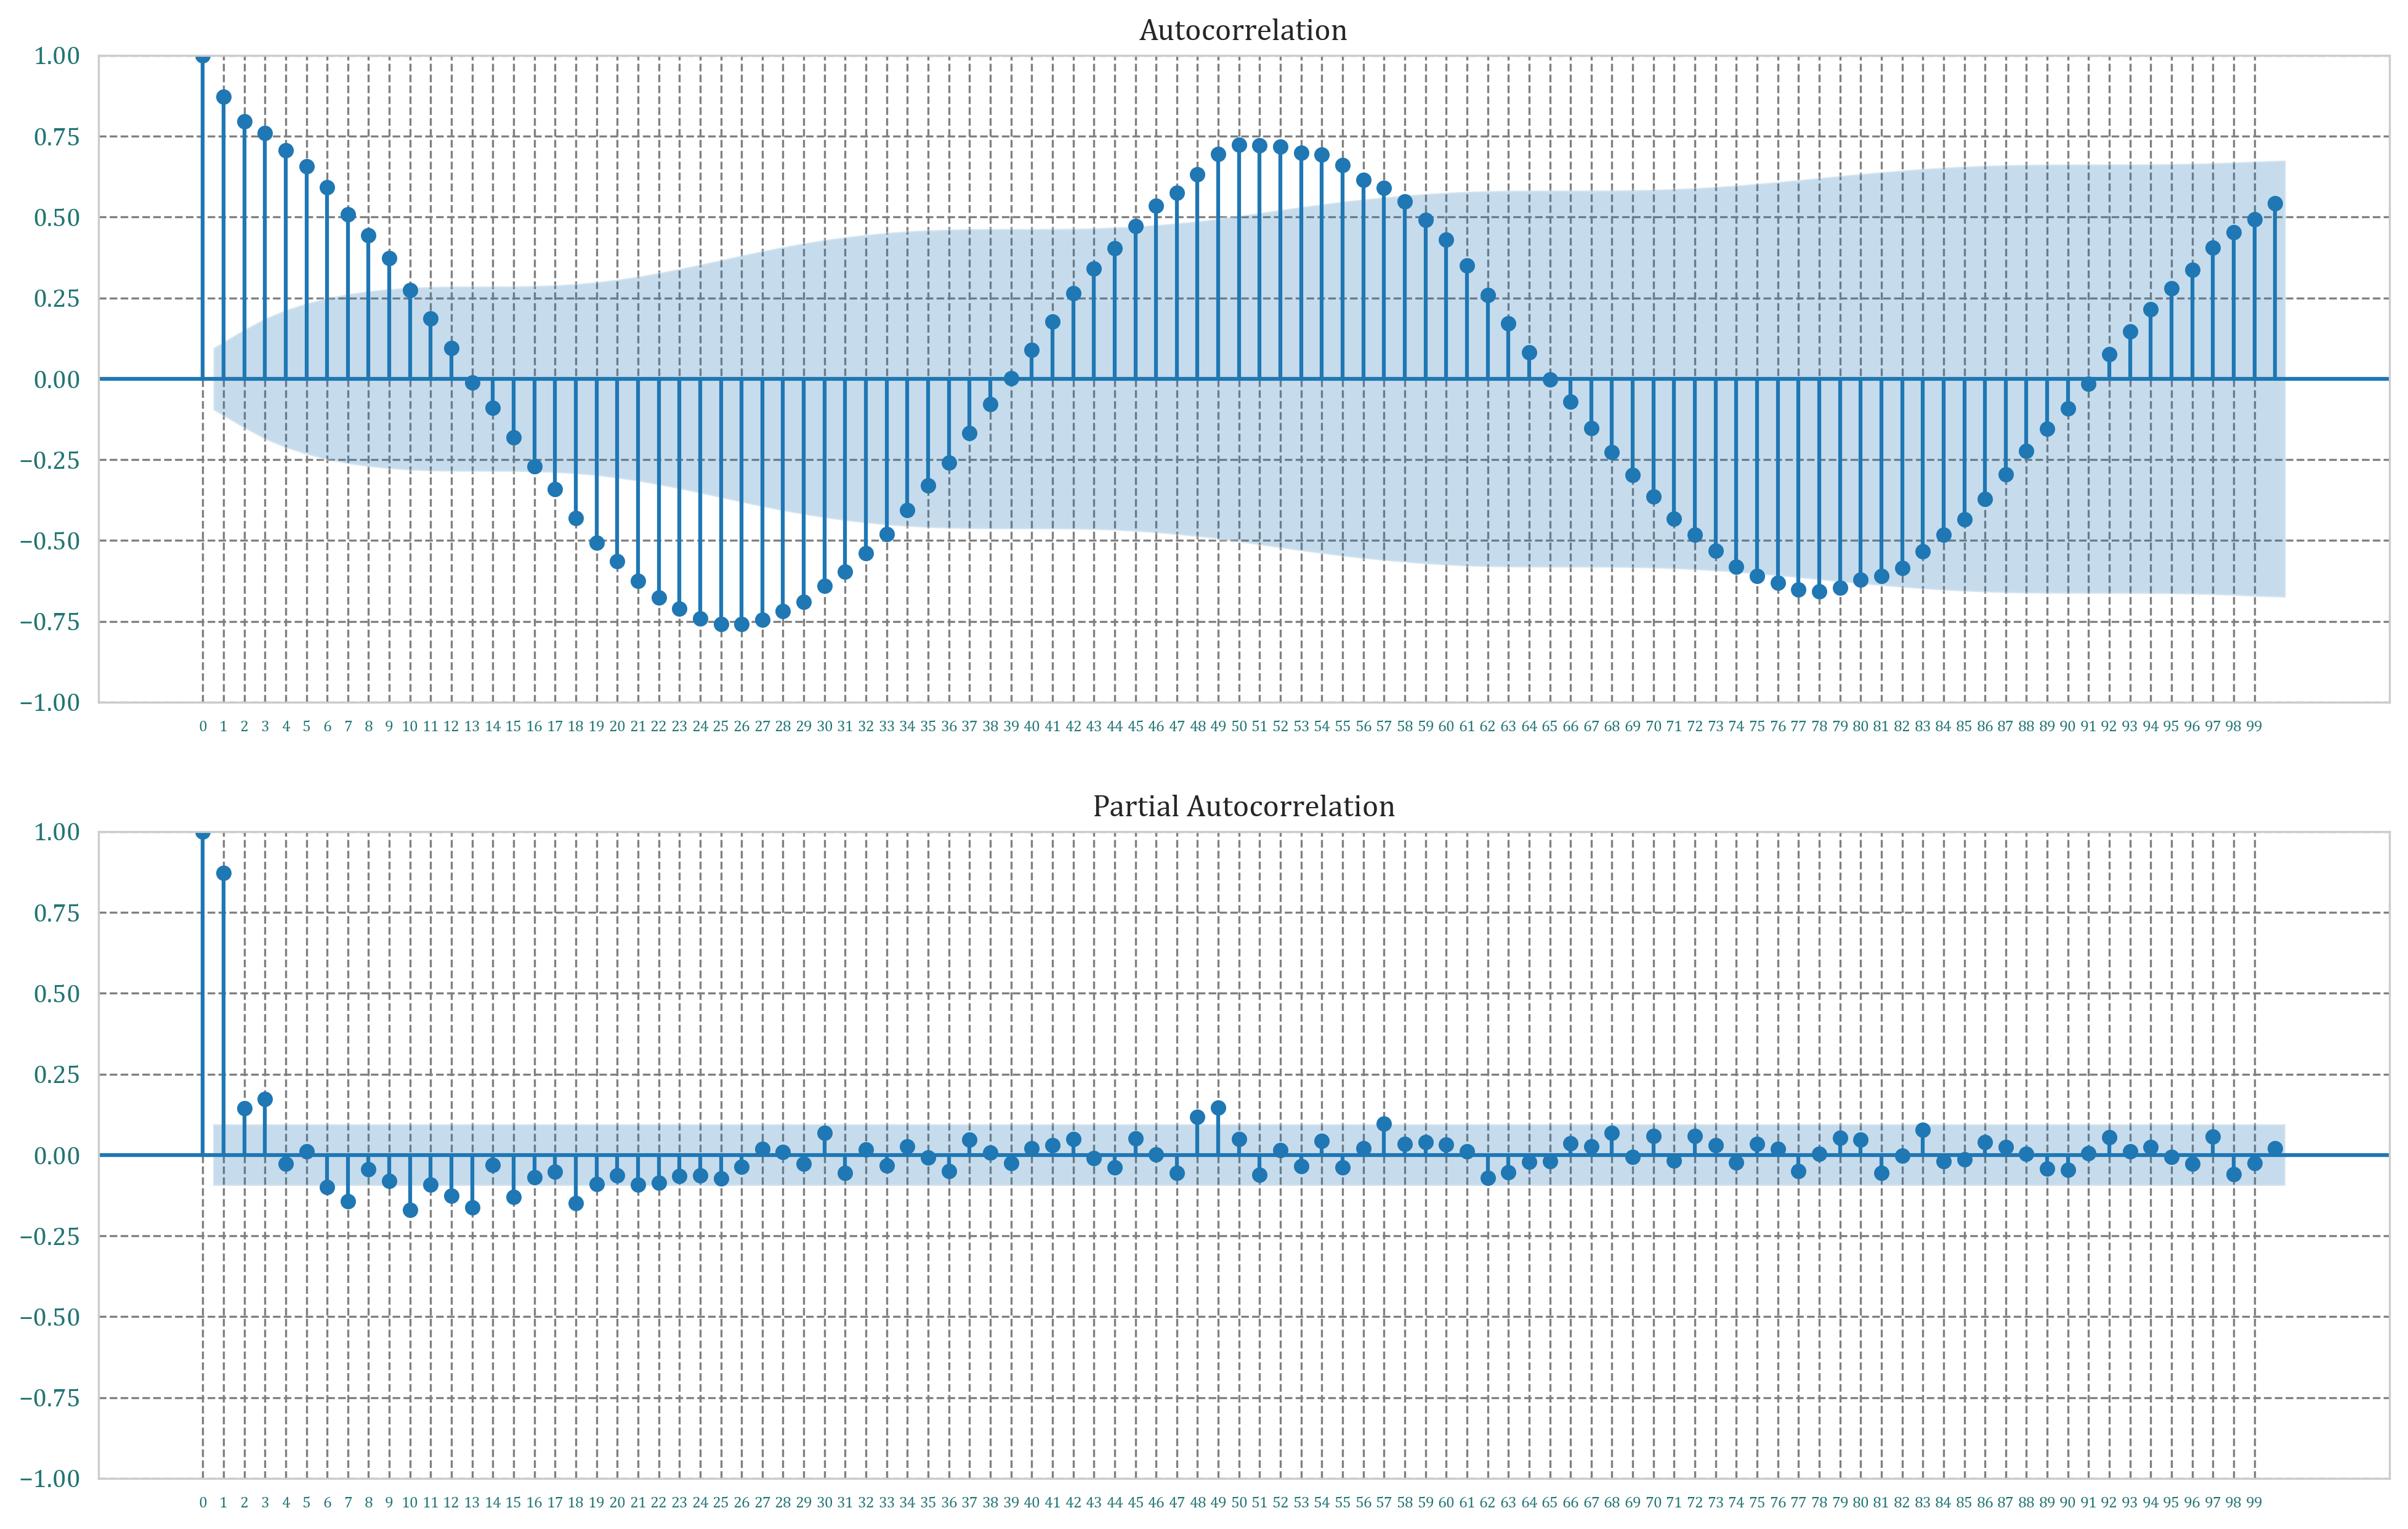

In [13]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), dpi=300)

plot_acf(df['temperature'], lags=100, ax=ax[0])
plot_pacf(df['temperature'], lags=100, ax=ax[1])

for a in ax:
    a.set_xticks(range(100))
    a.tick_params(axis='x', labelsize=6)
plt.show()

## 5. Results!

The ACF and PACF plots indicate significant correlations at lags **51** and **49** respectively, which are close to the expected yearly seasonality (52 weeks), suggesting a strong annual pattern in the time series.

---
# 4. Data modeling:
- Satisfied by your data ?
- Run simple clustering or regression.
- Evaluate your data modeling by choosing the right evaluatiors( clustering or regression).
- Make visualization.

---

## a. Data splitting:
   - split the data into experimental and testing

In [14]:
train_size = int(0.85 * len(df)) # 85% for training
test_size = len(df) - train_size # 15% for validation

df.reset_index(drop=False, inplace=True)
df.columns = ['ds', 'y']  # rename the columns

x_train, y_train = pd.DataFrame(df.iloc[:train_size, 0]), pd.DataFrame(df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(df.iloc[train_size:, 0]), pd.DataFrame(df.iloc[train_size:, 1])

len(df.index), len(x_train), len(x_valid)

(418, 355, 63)

## b. Choose the model

we will dive into the ARIMA model.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:

* **Auto-Regressive (AR) filter (long term):**  
  
  $y_t = c + \alpha_1 y_{t-1} + \dots + \alpha_p y_{t-p} + \epsilon_t = c + \sum_{i=1}^p \alpha_i y_{t-i} + \epsilon_t$  
  -> p

* **Integration filter (stochastic trend):**  
  
  -> d

* **Moving Average (MA) filter (short term):**  
  
  $y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_q \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q \beta_i \epsilon_{t-i}$  
  -> q

**ARIMA**:  
$y_t = c + \alpha_1 y_{t-1} + \dots + \alpha_p y_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_q \epsilon_{t-q}$

ARIMA(
*p*,
*d*,
*q*)

* *p*: Lag order (obtained from PACF plot analysis) and we've got about 49
* *d*: Degree of differencing. (got from Differencing experiment) and we've got 1
* *q*: Order of moving average (obtained from ACF plot analysis) and we've got 51

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train-test validation split to achieve this.
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.


In [15]:
# ARIMA params (more the params are big more the model is complex so we start with smaller 
# values and inhance them in the fine tuning phase)
P, D, Q = 20, 1, 10

# Fit model (30 to 60 seconds to fit)
model = ARIMA(y_train, order=(P, D, Q))
model_fit = model.fit()

## c. Making Predictions

Our next step is to forecast the weekly mean temperatures for the upcoming validation period. We will generate predictions for 63 weeks ahead, which corresponds to the length of our validation dataset. This forecast horizon allows us to thoroughly evaluate our model's performance by comparing predicted temperatures against actual observations throughout this extended period.

This prediction phase will help us assess the model's ability to capture both short-term fluctuations and longer-term seasonal patterns in temperature variations. The significant forecast period of more than a year enables us to evaluate the model's performance across different seasons and validate its reliability for operational use.

In [16]:
# Prediction with ARIMA
prediction = model_fit.get_prediction(start=0, end=len(x_train))
y_pred = prediction.predicted_mean

forecast = model_fit.get_forecast(steps=len(x_valid))
y_forcast = forecast.predicted_mean
conf = forecast.conf_int()

pd.DataFrame(data=y_forcast).set_index(x_valid['ds'])

,predicted_mean
ds,
2015-10-25,6.730395
2015-11-01,10.743499
2015-11-08,6.497752
2015-11-15,5.233782
2015-11-22,7.042483
...,...
2016-12-04,4.515201
2016-12-11,3.979588
2016-12-18,3.176146


## d. Visualize the forecasts

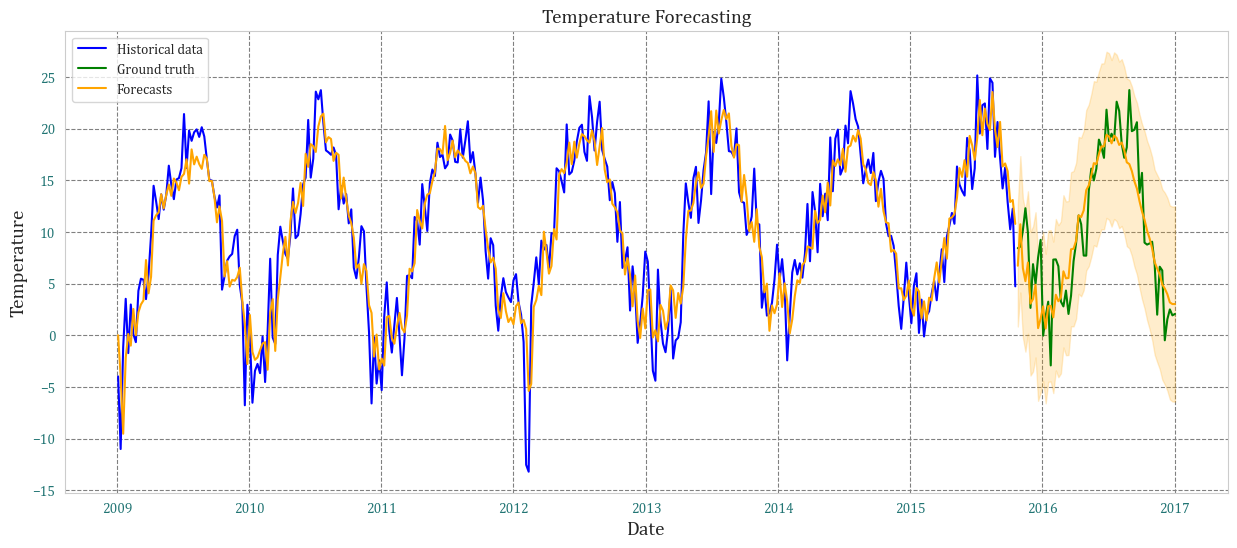

In [18]:
def plot_arima_results(train_timestamp, valid_timestamp, train, valid, pred, forecast, min_conf, max_conf):
    f, ax = plt.subplots(figsize=(15, 6))
    
    # actual timeseires
    sns.lineplot(x=train_timestamp, y=train, ax=ax, color='blue', label='Historical data')
    sns.lineplot(x=valid_timestamp, y=valid, ax=ax, color='green', label='Ground truth')
    
    # predicted timeseries
    sns.lineplot(x=train_timestamp, y=pred, ax=ax, color='orange', label='Forecasts')
    sns.lineplot(x=valid_timestamp, y=forecast, ax=ax, color='orange')
    ax.fill_between(x=valid_timestamp, y1=min_conf, y2=max_conf, color='orange', alpha=0.2)
    
    # Titles and labels
    ax.set_title('Temperature Forecasting', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Temperature', fontsize=14)
    ax.legend()
    plt.show()

plot_arima_results(
    train_timestamp=x_train['ds'],
    valid_timestamp=x_valid['ds'],
    train=y_train['y'],
    valid=y_valid['y'],
    pred=y_pred,
    forecast=y_forcast,
    min_conf=conf.iloc[:, 0],
    max_conf=conf.iloc[:, 1]
)

## e. Model evaluation

In [19]:
def evaluate_arima(actual, forecast):
    # Calculate metrics
    mae = mean_absolute_error(actual, forecast)
    rmse = math.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse


score_mae, score_rmse = evaluate_arima(y_valid, y_forcast)
print(f'RMSE: {score_rmse}, MAE: {score_mae}')

RMSE: 3.2121531532626304, MAE: 2.4141110267766903


## f. Fine-Tuning the ARIMA Model

ARIMA has variants like SARIMA (handles seasonality) and SARIMAX (handles seasonality + exogenous variables for improved accuracy). 

Here, we will continue with ARIMA.


In [20]:
def arima_fitter(model, data, order=(1,1,1)):
    # Initialize model with optimized settings
    model_instance = model(
        endog=data,
        order=order,
        enforce_stationarity=True,    # Disable stability check
        enforce_invertibility=False,    # Disable invertibility check
        concentrate_scale=True,         # Use concentrated likelihood
        # trend='t'                      # No trend by default for faster computation
    )
    
    # Fit the model with optimized settings
    fitted_model = model_instance.fit()
    
    return fitted_model


Evaluation result: ==============================
RMSE: 2.892829672232646, MAE: 2.337971330512346

Forecast visualization for model SARIMAX ========


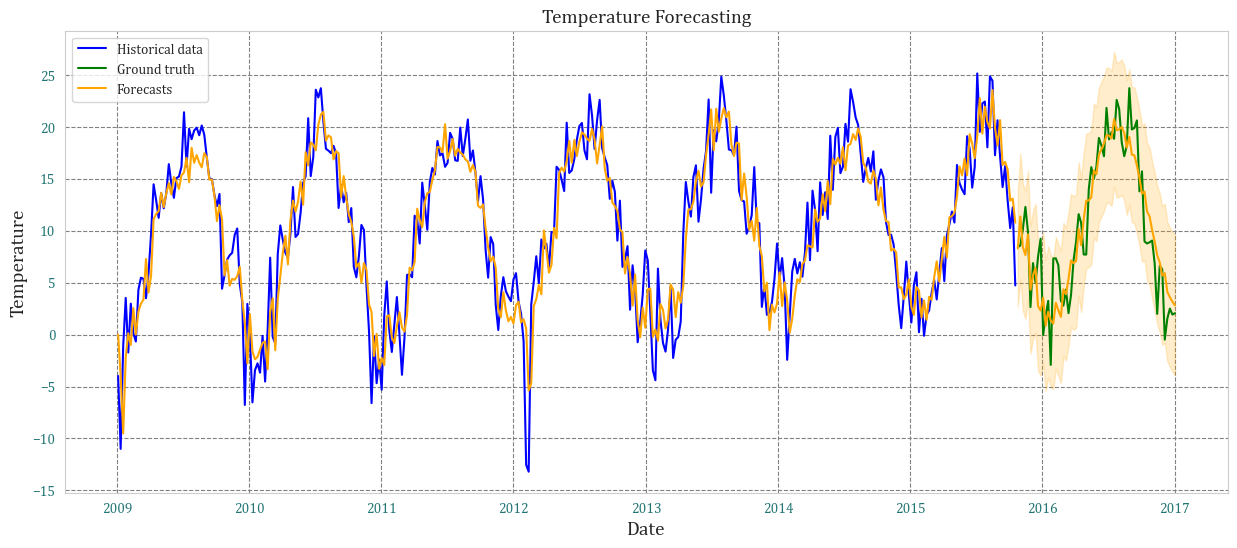

In [21]:
# increase the model params
P, D, Q= 30, 1, 25

# Fit model (it may take several minutes to run)
model_fit = arima_fitter(model=ARIMA, data=y_train, order=(P, D, Q))

# Prediction with SARIMAX
forecast = model_fit.get_forecast(steps=len(x_valid))
y_forcast = forecast.predicted_mean
conf = forecast.conf_int()

# evaluation
score_mae, score_rmse = evaluate_arima(y_valid, y_forcast)
print(f'\nEvaluation result:', '='*30)
print(f'RMSE: {score_rmse}, MAE: {score_mae}')
print('='*49)

# vizualization
print(f'\nForecast visualization for model SARIMAX', "="*8)
plot_arima_results(
    train_timestamp=x_train['ds'],
    valid_timestamp=x_valid['ds'],
    train=y_train['y'],
    valid=y_valid['y'],
    pred=y_pred,
    forecast=y_forcast,
    min_conf=conf.iloc[:, 0],
    max_conf=conf.iloc[:, 1]
)

---
# 5. Communicate results: 
- Provide textual description of your work.
- Use visualizations to simplify your findings, and communicate it.
- Any decisions based on facts ?
---

The model performs reasonably well but requires further refinement for detailed handling.

## -> Conclusion

In this notebook, we analyzed the Jena `temperature` dataset using historical data. We performed EDA with statistical tools such as the `ADF test`, `ACF`, and `PACF`. Then, we built a predictive model (`ARIMA`) to forecast future values.

**REMEMBER!** We used a time resolution from 10 minutes to 7 days to simplify the task. Now, we can forecast the mean temperature for the next week!
